<h2>
   시각화 
</h2>

<h3>
    1. 요일별 하루 평균 매출 분석
</h3>

In [221]:
# 데이터 로드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
weekly_sales_df = pd.read_csv('weekly_sales_df.csv')
sixday_sales_df=pd.read_csv('sixday_sales_df.csv')
holiday_sales_df=pd.read_csv('holiday_sales_df.csv')

In [222]:
avg_sale_per_day=weekly_sales_df.groupby(['date','weekday'],as_index=False)\
.agg(total_sum=('total_price','sum'))\
.groupby('weekday',as_index=False)\
.agg(day_per_sale=('total_sum','mean'))

In [223]:
# 요일 이름 리스트
weekday_labels= ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일','일요일']

# 기존 데이터프레임에 요일 이름 추가
avg_sale_per_day['weekday_name'] = avg_sale_per_day['weekday'].map(lambda x: weekday_labels[x])

C:\Users\bread\AppData\Local\Temp\ipykernel_9860\205116645.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sale_per_day, x='weekday_name', y='day_per_sale',palette=colors)


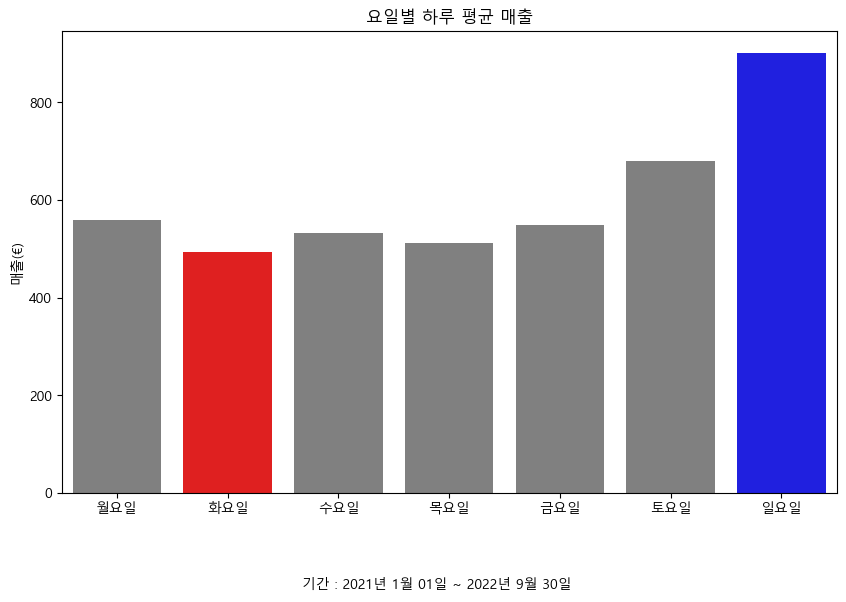

In [224]:
colors = ['gray'] * len(avg_sale_per_day)  # 기본 색상은 회색
max_idx = avg_sale_per_day['day_per_sale'].idxmax()  # 최대 매출 요일
min_idx = avg_sale_per_day['day_per_sale'].idxmin()  # 최소 매출 요일
colors[max_idx] = 'blue'  # 최대 매출: 파랑
colors[min_idx] = 'red'   # 최소 매출: 빨
# 한글 폰트 경로 설정 (Windows: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_sale_per_day, x='weekday_name', y='day_per_sale',palette=colors)
plt.title('요일별 하루 평균 매출')
plt.ylabel('매출(€)')
plt.xlabel('')
plt.xticks(rotation=0)
plt.figtext(0.5, -0.05, '기간 : 2021년 1월 01일 ~ 2022년 9월 30일', 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

<h3>
    2. 요일별 & 시간대별 평균 매출 시각화
</h3>

In [229]:
# 요일 & 시간 별로 평균 매출을 확인 할 수 있도록 전처리
avg_sale_per_day_hour=weekly_sales_df.groupby(['date','weekday','hour'],as_index=False)\
.agg(sum_price=('total_price','sum'))\
.groupby(['weekday','hour'],as_index=False)\
.agg(mean_price=('sum_price','mean'))

# 요일 숫자를 이름으로 변환
weekday_labels_map = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}
avg_sale_per_day_hour['weekday_name'] = avg_sale_per_day_hour['weekday'].map(weekday_labels_map)

# 요일 순서대로 정렬
avg_sale_per_day_hour['weekday_name'] = pd.Categorical(avg_sale_per_day_hour['weekday_name'], categories=weekday_labels, ordered=True)

C:\Users\bread\AppData\Local\Temp\ipykernel_9860\80857774.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  weekly_sales = avg_sale_per_day_hour.pivot_table(


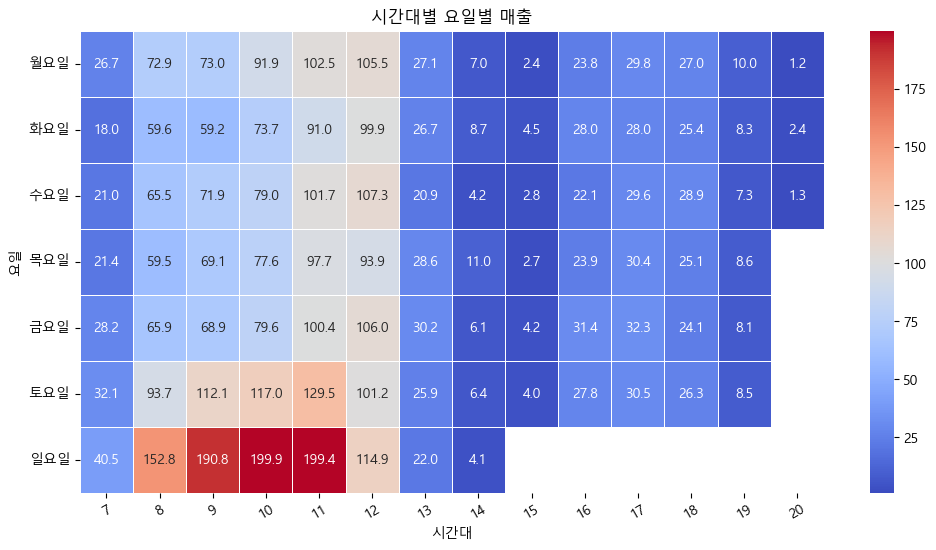

In [230]:
# 데이터 준비: 시간대와 요일별 평균 매출 계산
weekly_sales = avg_sale_per_day_hour.pivot_table(
    values='mean_price', index='weekday_name', columns='hour', aggfunc='mean'
)

# 히트맵 생성
plt.figure(figsize=(12, 6))
sns.heatmap(weekly_sales, cmap='coolwarm', annot=True, fmt='.1f', linewidths=0.5)

# 제목 및 레이블 설정
plt.title('시간대별 요일별 매출')
plt.xlabel('시간대')
plt.ylabel('요일')
plt.xticks(rotation=30)
plt.yticks(rotation=0)

plt.show()

<h3>
    3. 평일 상황별 매출 상위 제품 판매수량  분석  
</h3>

In [233]:
# 월 ~ 토요일 시간대 별 총 판매량 전처리 
sixday_part_sale=sixday_sales_df.groupby(['part_of_day','article'],as_index=False)\
.agg(Quantity_sum=('Quantity','sum'),
    total_sale=('total_price','sum'))

In [234]:
#아침에 팔린 빵 정보
sixday_morning_sale=sixday_part_sale.query('part_of_day == "아침"')\
.sort_values('Quantity_sum', ascending=False).head(5)

In [235]:
#점심에 팔린 빵 정보
sixday_lunch_sale=sixday_part_sale.query('part_of_day == "점심"')\
.sort_values('Quantity_sum', ascending=False).head(5)

In [237]:
#오후에 팔린 빵 정보
sixday_afternoon_sale=sixday_part_sale.query('part_of_day == "오후"')\
.sort_values('Quantity_sum', ascending=False).head(5)

In [238]:
# 월 ~ 토 시간대별 판매량 top5 빵 누적 막대 그래프로 나타내기 위한 전리리
sixday_sale_list=pd.concat([sixday_morning_sale['article'],sixday_lunch_sale['article'],sixday_afternoon_sale['article']],axis=0)
sixday_sale_list=sixday_sale_list.unique()
sixday_part_per_sale=sixday_sales_df[sixday_sales_df['article'].isin(sixday_sale_list)].groupby(['part_of_day','article'],as_index=False)\
.agg(Quantity_sum=('Quantity','sum'))

In [239]:
# 하루 평균 판매되는 빵의 수량을 구하기 위해 전처리 (해당 데이터 셋의 월 ~ 토휴일 수는 499일)
sixday_part_per_sale['Quantity_mean']=sixday_part_per_sale['Quantity_sum']/499

In [241]:
# 시각화 자료에서 한글로 표기하기 위해 딕셔너리 생성 
article_mapping = {
    'BAGUETTE':'바게트',
    'BANETTE':'빠네',
    'COUPE':'쿠페',
    'CROISSANT':'크루아상',
    'FORMULE SANDWICH':'샌드위치',
    'PAIN AU CHOCOLAT':'팽 오 쇼콜라',
    'TRADITIONAL BAGUETTE':'전통 바게트',
    'CEREAL BAGUETTE': '시리얼 바게트',
    'TARTELETTE' : '타르트',
    'SPECIAL BREAD' : '스페셜 브레드',
    'CAMPAGNE' : '깜빠뉴',
    'COOKIE' :'쿠키',
    'ECLAIR' : '에클레어',
    'COMPLET' : '통밀빵',
    'BOULE 400G' : '불 400g' ,
    'VIK BREAD': '스칸디나비아 빵',
    'ETC' : 'ETC'  
}

In [242]:
# 'article'별로 'part_of_day' (아침, 점심, 오후)별로 판매량의 합계를 계산하여 피벗 테이블 생성
sixday_part_per_sale = sixday_part_per_sale.pivot_table(index='article', columns='part_of_day', values='Quantity_mean', aggfunc='sum').fillna(0)
# 'part_of_day' 컬럼 순서를 '아침', '점심', '오후'로 재정렬
sixday_part_per_sale = sixday_part_per_sale.reindex(columns=['아침','점심','오후'])

In [243]:
# article_mapping 딕셔너리를 사용하여 'article' 인덱스를 새로운 이름으로 변경
sixday_part_per_sale = sixday_part_per_sale.rename(index=article_mapping)

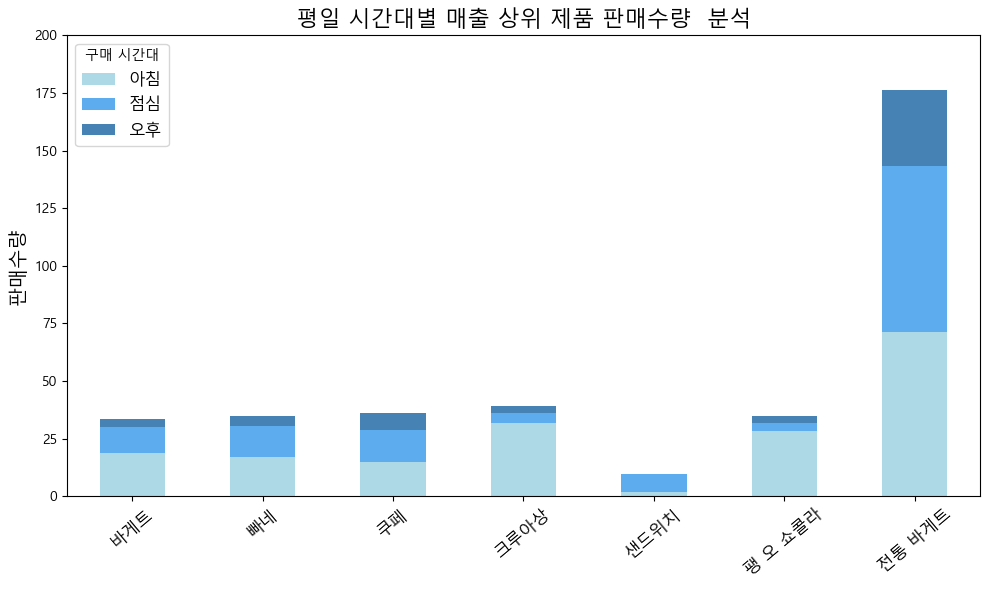

In [245]:
# 누적 막대그래프 생성
colors = ['#ADD8E6', '#5CACEE', '#4682B4']
sixday_part_per_sale.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# 그래프 꾸미기
plt.rc('font', family='Malgun Gothic')
plt.title('평일 시간대별 매출 상위 제품 판매수량  분석', fontsize=16)
plt.ylabel('판매수량', fontsize=14)
plt.xlabel('')
plt.ylim(0,200)
plt.xticks(rotation=40, fontsize=12)
plt.legend(title='구매 시간대', fontsize=12)
plt.tight_layout()

<h3>
    4. 공휴일 시간대별 매출 상위 제품 판매수량  분석  
</h3>

In [249]:
# 일 + 공휴일 시간대 별 총 판매량 전처리 
holiday_part_sale=holiday_sales_df.groupby(['part_of_day','article'],as_index=False)\
.agg(Quantity_sum=('Quantity','sum'),
    total_sale=('total_price','sum'))

In [250]:
#아침에 팔린 빵 정보
holiday_morning_sale=holiday_part_sale.query('part_of_day == "아침"')\
.sort_values('Quantity_sum', ascending=False).head(5)

In [253]:
#점심에 팔린 빵 정보
holiday_lunch_sale=holiday_part_sale.query('part_of_day == "점심"')\
.sort_values('Quantity_sum', ascending=False).head(5)

In [256]:
# 일 + 공휴일 시간대별 판매량 top5 빵 누적 막대 그래프로 나타내기 위한 전리리
holiday_sale_list=pd.concat([holiday_morning_sale['article'],holiday_lunch_sale['article']],axis=0)
holiday_sale_list=holiday_sale_list.unique()
holiday_part_per_sale=holiday_sales_df[holiday_sales_df['article'].isin(holiday_sale_list)].groupby(['part_of_day','article'],as_index=False)\
.agg(Quantity_sum=('Quantity','sum'))

In [259]:
# 하루 평균 판매되는 빵의 수량을 구하기 위한 전처리 (해당 데이터 셋의 일 + 공휴일 수는 101일)
holiday_part_per_sale['Quantity_mean']=holiday_part_per_sale['Quantity_sum']/101

In [260]:
# 'article'별로 'part_of_day' (아침, 점심)별로 판매량의 합계를 계산하여 피벗 테이블 생성
holiday_part_per_sale = holiday_part_per_sale.pivot_table(index='article', columns='part_of_day', values='Quantity_mean', aggfunc='sum').fillna(0)
# 'part_of_day' 컬럼 순서를 '아침', '점심'으로 재정렬
holiday_part_per_sale = holiday_part_per_sale.reindex(columns=['아침','점심'])
# article_mapping 딕셔너리를 사용하여 'article' 인덱스를 새로운 이름으로 변경
holiday_part_per_sale = holiday_part_per_sale.rename(index=article_mapping)

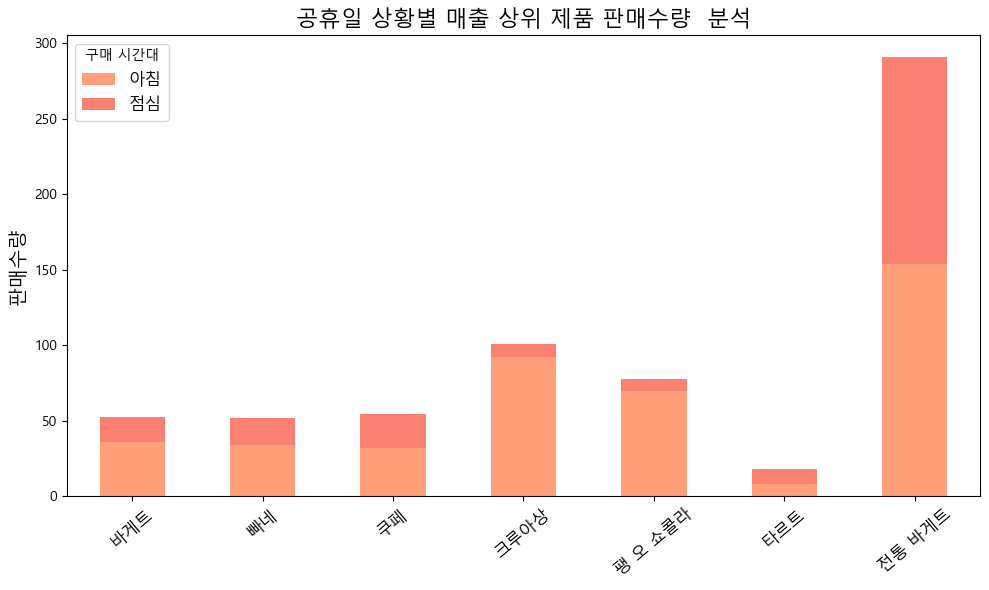

In [261]:
# 누적 막대그래프 생성
colors = ['#FFA07A', '#FA8072']
holiday_part_per_sale.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# 그래프 꾸미기
plt.rc('font', family='Malgun Gothic')
plt.title('공휴일 상황별 매출 상위 제품 판매수량  분석', fontsize=16)
plt.ylabel('판매수량', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=40, fontsize=12)
plt.legend(title='구매 시간대', fontsize=12)
plt.tight_layout()

<h2>
   전략 제안
</h2>

<h3>
    5. 평일/주말 13시 매출 개선 전략 증거 시각화
</h3>

In [265]:
sixday_percent=sixday_sales_df[sixday_sales_df['hour']==13].groupby('article',as_index=False)\
.agg(total_order=('Quantity','sum'),
    total_price=('total_price','sum'))

In [266]:
sixday_percent['rate']=(sixday_percent['total_order']/sum(sixday_percent['total_order']))*100

In [267]:
sixday_percent['grouped_article'] = sixday_percent['article']
sixday_percent.loc[sixday_percent['rate'] <= 3.5, 'grouped_article'] = 'ETC'
# 그룹별 rate 합산
grouped_sixday_percent = sixday_percent.groupby('grouped_article', as_index=False)['rate'].sum().sort_values('rate',ascending=False)
grouped_sixday_percent['grouped_article'] = grouped_sixday_percent['grouped_article'].map(article_mapping)

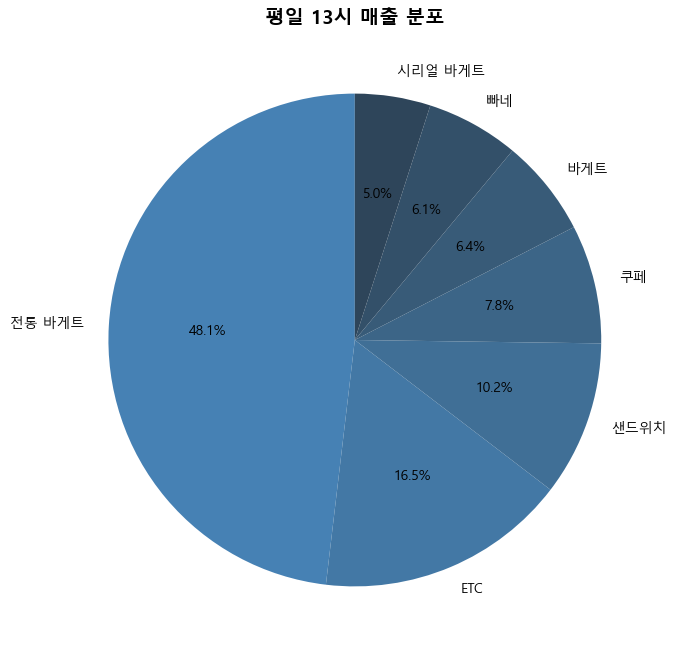

In [270]:
import colorsys 
# 기본 색상 (파란색 계열)
base_color = '#4682B4'  # SteelBlue

# 색상 생성 함수: 채도와 밝기를 자연스럽게 조절하여 색상 톤 만들기
def generate_shades(base_color, num_shades):
    # base_color를 RGB로 변환
    base_rgb = [int(base_color[i:i+2], 16)/255.0 for i in (1, 3, 5)]
    base_hsv = colorsys.rgb_to_hsv(base_rgb[0], base_rgb[1], base_rgb[2])
    
    shades = []
    for i in range(num_shades):
        # 채도(0.6 ~ 1.0)와 밝기(0.6 ~ 1.0) 비율로 변화
        new_hsv = (base_hsv[0], base_hsv[1] * (0.8 + 0.2 * i / (num_shades-1)), base_hsv[2] * (0.5 + 0.5 * i / (num_shades-1)))
        rgb = colorsys.hsv_to_rgb(new_hsv[0], new_hsv[1], new_hsv[2])
        hex_color = '#{0:02x}{1:02x}{2:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        shades.append(hex_color)
    return shades

# 색상 리스트 생성
blue_shades = generate_shades(base_color, len(grouped_sixday_percent))

# 색상 리스트를 역순으로 뒤집기
blue_shades_reverse = blue_shades[::-1]

# 원 그래프 그리기 (채도와 명도를 자연스럽게 변화, 역순 색상 적용)
plt.figure(figsize=(8, 8))
plt.pie(grouped_sixday_percent['rate'], 
        labels=grouped_sixday_percent['grouped_article'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=blue_shades_reverse)  # 역순 색상 적용
plt.title("평일 13시 매출 분포", fontsize=14, fontweight='bold')
plt.show()


In [271]:
# 주말 13시 시간대 매출 중 제품 비율 전처리 
holiday_percent=holiday_sales_df[holiday_sales_df['hour']==13].groupby('article',as_index=False)\
.agg(total_order=('Quantity','sum'),
    total_price=('total_price','sum'))

In [272]:
# 파이 그래프 시각화를 위한 전처리
holiday_percent['rate']=(holiday_percent['total_order']/sum(holiday_percent['total_order']))*100

In [273]:
# rate가 3.5 이하인 제품들은 ETC로 묶기
holiday_percent['grouped_article'] = holiday_percent['article']
holiday_percent.loc[holiday_percent['rate'] <= 3.5, 'grouped_article'] = 'ETC'

# 그룹별 rate 합산
grouped_holiday_percent = holiday_percent.groupby('grouped_article', as_index=False)['rate'].sum().sort_values('rate',ascending=False)
grouped_holiday_percent['grouped_article'] = grouped_holiday_percent['grouped_article'].map(article_mapping)


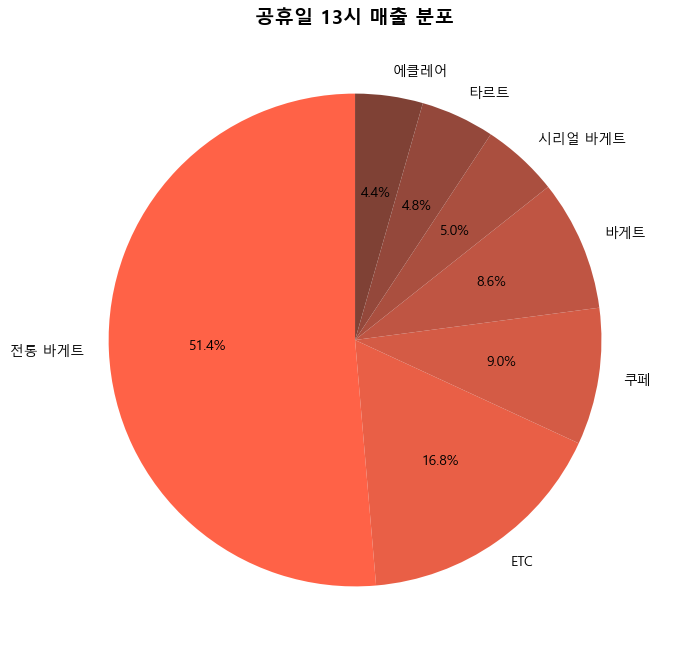

In [275]:
# 기본 색상 (빨간색 계열)
base_color = '#FF6347'  # Tomato (빨간색 계열)

# 색상 생성 함수: 채도와 밝기를 자연스럽게 조절하여 색상 톤 만들기
def generate_shades(base_color, num_shades):
    # base_color를 RGB로 변환
    base_rgb = [int(base_color[i:i+2], 16)/255.0 for i in (1, 3, 5)]
    base_hsv = colorsys.rgb_to_hsv(base_rgb[0], base_rgb[1], base_rgb[2])
    
    shades = []
    for i in range(num_shades):
        # 채도(0.6 ~ 1.0)와 밝기(0.6 ~ 1.0) 비율로 변화
        new_hsv = (base_hsv[0], base_hsv[1] * (0.8 + 0.2 * i / (num_shades-1)), base_hsv[2] * (0.5 + 0.5 * i / (num_shades-1)))
        rgb = colorsys.hsv_to_rgb(new_hsv[0], new_hsv[1], new_hsv[2])
        hex_color = '#{0:02x}{1:02x}{2:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        shades.append(hex_color)
    return shades

# 색상 리스트 생성
red_shades = generate_shades(base_color, len(grouped_holiday_percent))

# 색상 리스트를 역순으로 뒤집기
red_shades_reverse = red_shades[::-1]

# 원 그래프 그리기 (채도와 명도를 자연스럽게 변화, 역순 색상 적용)
plt.figure(figsize=(8, 8))
plt.pie(grouped_holiday_percent['rate'], 
        labels=grouped_holiday_percent['grouped_article'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=red_shades_reverse)  # 역순 색상 적용
plt.title("공휴일 13시 매출 분포", fontsize=14, fontweight='bold')
plt.show()


<h3>
    6. 매장 운영 시간 조정 근거 시각화
</h3>

In [278]:
# 년-월로 x축 표시를 위해 컬럼 추가
sixday_sales_df['date']=sixday_sales_df['date'].astype('datetime64[ns]')
sixday_sales_df['year_month'] = sixday_sales_df['date'].dt.to_period('M')

In [279]:
# 19시 이전 판매 데이터 전처리
sixday_time_renewal=sixday_sales_df.loc[sixday_sales_df['hour']<19].groupby(['date','year_month'],as_index=False)\
.agg(total_sale=('total_price','sum'))\
.groupby('year_month',as_index=False)\
.agg(month_total_sale=('total_sale','mean'))

In [281]:
# 기존 판매 데이터 전처리
sixday_time_og=sixday_sales_df.groupby(['date','year_month'],as_index=False)\
.agg(total_sale=('total_price','sum'))\
.groupby('year_month',as_index=False)\
.agg(month_total_sale=('total_sale','mean'))

In [283]:
# 증감액 계산
sixday_time_diff = sixday_time_og.merge(
    sixday_time_renewal, on='year_month', suffixes=('_og', '_renewal')
)
sixday_time_diff['sale_diff'] = sixday_time_diff['month_total_sale_og'] - sixday_time_diff['month_total_sale_renewal']


In [284]:
# 'year_month'를 datetime으로 변환
sixday_time_diff['year_month'] = sixday_time_diff['year_month'].dt.to_timestamp()


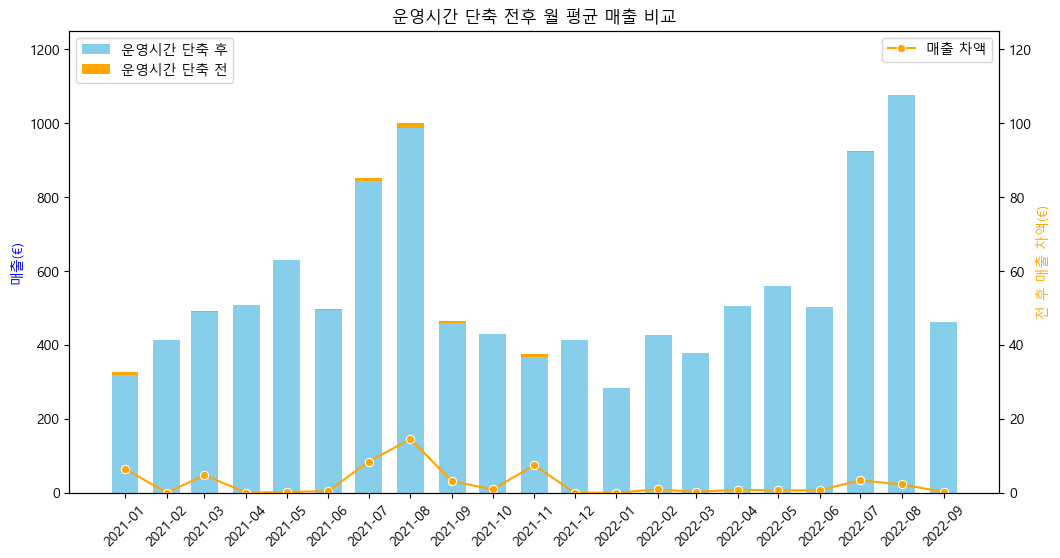

In [285]:
# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 스택형 막대그래프 (변경 전, 변경 후 매출)
ax1.bar(sixday_time_diff['year_month'], sixday_time_diff['month_total_sale_og'], color='skyblue', label='운영시간 단축 후', width=20)  
ax1.bar(sixday_time_diff['year_month'], sixday_time_diff['sale_diff'],
        bottom=sixday_time_diff['month_total_sale_og'], color='orange', label='운영시간 단축 전', width=20)

# 선 그래프 (매출 증감액)
ax2 = ax1.twinx()  # 두 번째 y축을 추가
sns.lineplot(x='year_month', y='sale_diff', data=sixday_time_diff, color='orange', ax=ax2, label='매출 차액', marker='o')

# 레이블 및 제목 추가
ax1.set_xlabel('')
ax1.set_ylabel('매출(€)', color='blue')
ax2.set_ylabel('전 후 매출 차액(€)', color='orange')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1250)
ax2.set_ylim(0, 125)

# 제목 추가
plt.title('운영시간 단축 전후 월 평균 매출 비교')


# 모든 x 축 값 설정
ax1.set_xticks(sixday_time_diff['year_month'])
ax1.set_xticklabels(sixday_time_diff['year_month'].dt.strftime('%Y-%m'), rotation=45)

# 범례 추가
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


<h3>
    7. 토요일 매장 방문 증가를 위한 방안 근거 시각화
</h3>

In [288]:
satday_data=sixday_sales_df[sixday_sales_df['weekday']==5]

In [290]:
sat_data=sixday_sales_df[sixday_sales_df['weekday']==5].groupby(['part_of_day','article'],as_index=False)\
.agg(total_order=('Quantity','sum'),
    total_sale=('total_price','sum'))

In [292]:
sat_morning_sale=sat_data.query('part_of_day == "아침"')\
.sort_values('total_order', ascending=False).head(5)

In [294]:
sat_lunch_sale=sat_data.query('part_of_day == "점심"')\
.sort_values('total_order', ascending=False).head(5)

In [295]:
satday_sale_list=pd.concat([sat_morning_sale['article'],sat_lunch_sale['article']],axis=0)
satday_sale_list=satday_sale_list.unique()
satday_sale=satday_data[satday_data['article'].isin(satday_sale_list)].groupby(['part_of_day','article'],as_index=False)\
.agg(total_order=('Quantity','sum'))

In [296]:
satday_sale['mean_order']=satday_sale['total_order']/87

In [298]:
satday_part_per_sale = satday_sale.pivot_table(index='article', columns='part_of_day', values='mean_order', aggfunc='sum').fillna(0)
satday_part_per_sale = satday_part_per_sale.reindex(columns=['아침','점심'])
satday_part_per_sale = satday_part_per_sale.rename(index=article_mapping)

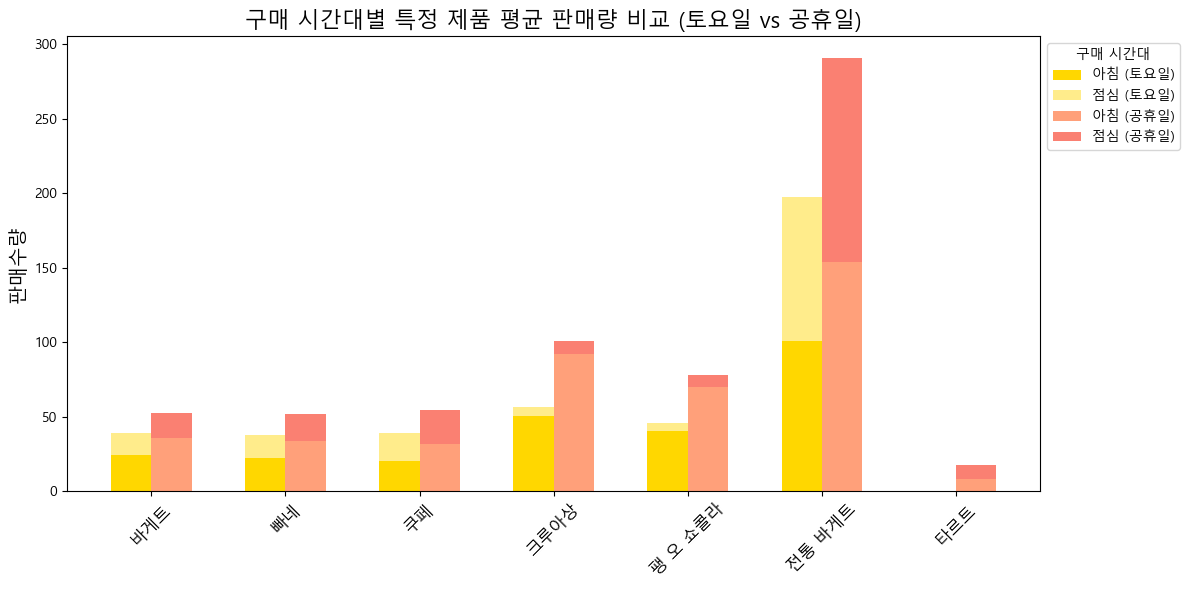

In [301]:
# 데이터 병합 및 정리
comparison_data = pd.concat(
    [satday_part_per_sale.rename(columns=lambda x: f'{x} (토요일)'),
     holiday_part_per_sale.rename(columns=lambda x: f'{x} (공휴일)')],
    axis=1
).fillna(0)

# 막대그래프 데이터 준비
x = np.arange(len(comparison_data.index))  # 제품별 위치
bar_width = 0.3  # 막대 너비

# 색상 설정
satday_colors = ['#FFD700', '#FFEC8B']    # 평일: 아침, 점심, 저녁 (밝은 파랑 -> 어두운 파랑)
holiday_colors = ['#FFA07A', '#FA8072']  # 공휴일: 아침, 점심, 저녁 (밝은 빨강 -> 어두운 빨강)

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 6))

# 평일 데이터 막대
ax.bar(
    x - bar_width / 2,
    comparison_data['아침 (토요일)'],
    bar_width,
    label='아침 (토요일)',
    color=satday_colors[0]
)
ax.bar(
    x - bar_width / 2,
    comparison_data['점심 (토요일)'],
    bar_width,
    bottom=comparison_data['아침 (토요일)'],
    label='점심 (토요일)',
    color=satday_colors[1]
)

# 공휴일 데이터 막대
ax.bar(
    x + bar_width / 2,
    comparison_data['아침 (공휴일)'],
    bar_width,
    label='아침 (공휴일)',
    color=holiday_colors[0]
)
ax.bar(
    x + bar_width / 2,
    comparison_data['점심 (공휴일)'],
    bar_width,
    bottom=comparison_data['아침 (공휴일)'],
    label='점심 (공휴일)',
    color=holiday_colors[1]
)

# 그래프 꾸미기
ax.set_title('구매 시간대별 특정 제품 평균 판매량 비교 (토요일 vs 공휴일)', fontsize=16)
ax.set_ylabel('판매수량', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_data.index, rotation=45, fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='구매 시간대')
plt.tight_layout()

plt.show()


<h3>
    8. 월~ 토요일 오후(16~19시)  매출 저조 해결 방안 근거 시각화
</h3>

In [304]:
# ticket_number로 그룹화하여 각 주문에 포함된 제품 리스트 생성
basket = sixday_sales_df[sixday_sales_df['hour'].isin([15,16,17,18])].groupby('ticket_number')['article'].apply(list).reset_index()


In [306]:
from itertools import combinations
from collections import Counter

# 모든 주문에 대해 순서를 무시한 2개 이상의 제품 조합 생성
all_combinations = []

for order in basket['article']:
    # 제품들을 정렬하여 순서가 다르더라도 같은 조합으로 취급
    sorted_order = sorted(order)  # 제품 순서 정렬
    combinations_list = list(combinations(sorted_order, 2))  # 2개 제품 조합을 생성
    all_combinations.extend(combinations_list)

# 제품 조합 빈도 계산
combination_counts = Counter(all_combinations)
# 상위 5개의 제품 조합 추출
top_combinations = combination_counts.most_common(5)

In [311]:
# 제품 조합 데이터프레임을 만들었다고 가정
df_combinations = pd.DataFrame(top_combinations, columns=['combination', 'count'])

# 각 조합을 한글로 변환
df_combinations['combination_kr'] = df_combinations['combination'].apply(
    lambda x: (article_mapping[x[0]], article_mapping[x[1]])
)


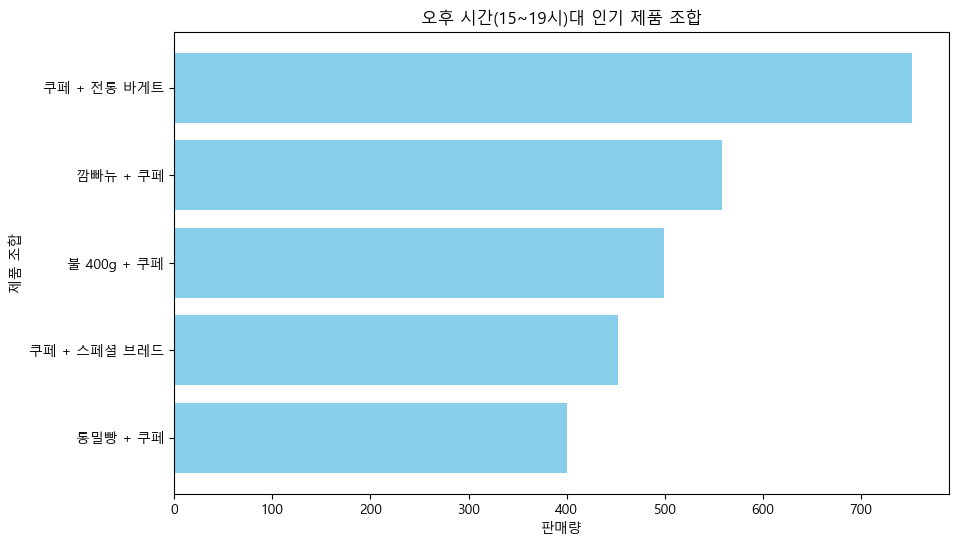

In [315]:
# 한글 폰트 설정 (예제: 맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 시각화
plt.figure(figsize=(10, 6))
pairs = [f"{p1} + {p2}" for p1, p2 in df_combinations['combination_kr']]
counts = df_combinations['count']

plt.barh(pairs, counts, color='skyblue')
plt.xlabel("판매량")
plt.ylabel("제품 조합")
plt.title("오후 시간(15~19시)대 인기 제품 조합")
plt.gca().invert_yaxis()  # 가장 많은 조합이 위로 오게 정렬
plt.show()
